# Dfsu - 2D interpolation
This notebook demonstrates how to interpolate dfsu data to a grid, how to save the gridded data as dfs2 and geotiff. It also shows how to interpolate dfsu data to another mesh. 

In [1]:
import mikeio

In [2]:
ds = mikeio.read("../tests/testdata/wind_north_sea.dfsu", items="Wind speed")
ds

<mikeio.Dataset>
dims: (time:6, element:958)
time: 2017-10-27 00:00:00 - 2017-10-27 05:00:00 (6 records)
geometry: Dfsu2D (958 elements, 570 nodes)
items:
  0:  Wind speed <Wind speed> (meter per sec)

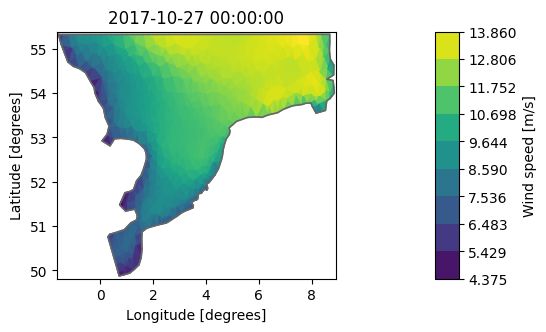

In [3]:
da = ds.Wind_speed
da.plot();

## Interpolate to grid
1. Get an overset grid covering the domain
2. Then interpolate all data to the new grid and plot. 
4. The interpolated data is then saved to a dfs2 file.

In [4]:
g = da.geometry.get_overset_grid(dx=0.1)
g

<mikeio.Grid2D>
x: [-1.563, -1.463, ..., 8.837] (nx=105, dx=0.1)
y: [49.9, 50, ..., 55.3] (ny=55, dy=0.1)
projection: LONG/LAT

In [5]:
da_grid = da.interp_like(g)
da_grid

<mikeio.DataArray>
name: Wind speed
dims: (time:6, y:55, x:105)
time: 2017-10-27 00:00:00 - 2017-10-27 05:00:00 (6 records)
geometry: Grid2D (ny=55, nx=105)

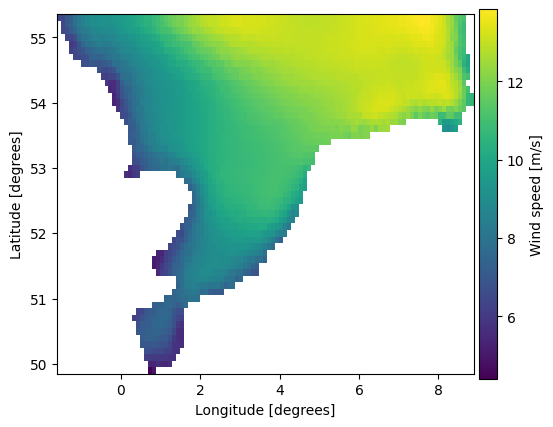

In [6]:
da_grid.plot();

## Save to dfs2 file

In [7]:
da_grid.to_dfs("wind_north_sea_interpolated.dfs2")

![](../images/dfsu_grid_interp.png)

## Save to NetCDF

In [8]:
xr_da = da_grid.to_xarray()
xr_da.to_netcdf("wind_north_sea_interpolated.nc")

![](../images/dfsu_grid_netcdf.png)

## Save to GeoTiff

Using [rasterio](https://rasterio.readthedocs.io/en/latest/index.html)

In [ ]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

with rasterio.open(
     fp='wind.tif',
     mode='w',
     driver='GTiff',
     height=g.ny,
     width=g.nx,
     count=1,
     dtype=da.dtype,
     crs='+proj=latlong', # adjust accordingly for projected coordinate systems
     transform=from_origin(g.bbox.left, g.bbox.top, g.dx, g.dy)
     ) as dst:
        dst.write(np.flipud(da_grid[0].to_numpy()), 1) # first time_step
    

![](../images/dfsu_grid_interp_tiff.png)

# Interpolate to other mesh
Interpolate the data from this coarse mesh onto a finer resolution mesh


In [10]:
msh = mikeio.Mesh('../tests/testdata/north_sea_2.mesh')
msh

<Mesh>
number of nodes: 1296
number of elements: 2259
projection: LONG/LAT

In [12]:
dsi = da.interp_like(msh.geometry)
dsi

<mikeio.DataArray>
name: Wind speed
dims: (time:6, element:2259)
time: 2017-10-27 00:00:00 - 2017-10-27 05:00:00 (6 records)
geometry: Dfsu2D (2259 elements, 1296 nodes)

In [ ]:
da[0].plot(figsize=(9,7), show_mesh=True);

In [ ]:
dsi[0].plot(figsize=(9,7), show_mesh=True);

### Note: 3 of the new elements are outside the original mesh and data are therefore NaN by default

In [ ]:
nan_elements = np.where(np.isnan(dsi[0].to_numpy()))[0]
nan_elements


In [ ]:
da.geometry.contains(msh.element_coordinates[nan_elements,:2])

### We can force extrapolation to avoid the NaN values

In [ ]:
dat_interp = da.interp_like(msh.geometry, extrapolate=True)

In [ ]:
n_nan_elements = np.sum(np.isnan(dat_interp.values))
n_nan_elements

## Interpolate scatter data to mesh

We want to interpolate scatter data onto an existing mesh and create a new dfsu with the interpolated data. 

**This uses lower level private utility methods not part of the public API**.

In [ ]:
from mikeio.spatial._distance import dist_in_meters
from mikeio._interpolation import get_idw_interpolant

In [ ]:
dfs = mikeio.open('../tests/testdata/wind_north_sea.dfsu')

In [ ]:
dfs.geometry.plot.mesh();

In [ ]:
# scatter data: x,y,value for 4 points
scatter= np.array([[1,50,1], [4, 52, 3], [8, 55, 2], [-1, 55, 1.5]])
scatter

Let's first try the approx for a single element: 

* calc distance to all interpolation points
* calc IDW interpolatant weights
* Interpolate

In [ ]:
dist = dist_in_meters(scatter[:,:2], dfs.geometry.element_coordinates[0,:2])
dist

In [ ]:
w = get_idw_interpolant(dist, p=2)
w

In [ ]:
np.dot(scatter[:,2], w) # interpolated value in element 0

Let's do the same for all points in the mesh and plot in the end

In [ ]:
dati = np.zeros((1,dfs.geometry.n_elements))
for j in range(dfs.geometry.n_elements):
    dist = dist_in_meters(scatter[:,:2], dfs.geometry.element_coordinates[j,:2])
    w = get_idw_interpolant(dist, p=2)
    dati[0,j] = np.dot(scatter[:,2], w)

In [ ]:
da = mikeio.DataArray(data=dati, geometry=dfs.geometry, time=dfs.start_time)
da

In [ ]:
da.plot(title="Interpolated scatter data");

In [ ]:
da.to_dfs("interpolated_scatter.dfsu")

## Clean up

In [ ]:
import os

os.remove("wind_north_sea_interpolated.dfs2")
os.remove("wind_north_sea_interpolated.nc")
os.remove("wind.tif")
os.remove("interpolated_scatter.dfsu")